# LSTM CAMELS-ES: resultados
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 30-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se analizan los resultados del modelo LSTM que simula el caudal observado del conjunto de datos CAMELS-ES a partir de las series meteorológicas de ERA5 y los atributos estáticos derivados de HydroATLAS.

**Por hacer**:

In [1]:
import os
ruta_base = os.getcwd()
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from neuralhydrology.utils.config import Config
from neuralhydrology.nh_run import eval_run
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
import yaml

os.chdir('../')
from model_utils import *
os.chdir('../1_Pretratamiento/')
from metricas_rendimiento import KGE, KGEmod, ECDF
from plot import rendimiento_LSTM
os.chdir(ruta_base)

In [2]:
# Set the default text font size
plt.rc('font', size=13)
# Set the axes title font size
plt.rc('axes', titlesize=14)
# Set the axes labels font size
plt.rc('axes', labelsize=13)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)
# Set the legend font size
plt.rc('legend', fontsize=12)
# Set the font size of the figure title
plt.rc('figure', titlesize=15)

plt.rcParams['font.family'] = 'Palatino Linotype'

## Configuración

In [3]:
# rutas de entrada y salida de datos
path_data = Path('../../../data/')
path_anuario = path_data / 'anuario_aforos'
path_camels = path_data / 'CAMELS-ES'
path_efas = path_data / 'EFAS5'

In [4]:
# definir simulación
run = 'CAMELS-ES_hidden128_3009_202924'
# run = 'CAMELS-ES_end_1609_085851' # 'CAMELS-ES_base_1009_154131'
hidrogramas = False

## Capas GIS

### Demarcaciones hidrográficas

In [5]:
demarcaciones = gpd.read_file(path_data / 'cartografia/hidrografia/demarcaciones.shp')
mask = demarcaciones.NOM_DEMAR.isin(['CANTABRICO ORIENTAL', 'CANTABRICO OCCIDENTAL', 'DUERO', 'EBRO', 'GALICIA-COSTA',
                                     'GUADALQUIVIR', 'GUADIANA', 'JUCAR', 'MIÑO-SIL', 'SEGURA', 'TAJO'])
demarcaciones = demarcaciones[mask]

### Estaciones

In [6]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)
estaciones = estaciones.loc[estaciones.sel == 1]
# estaciones.index = estaciones.index.astype(int)

# definir qué estaciones se usan en el entrenamiento, validación y test
for period in ['train', 'validation', 'test']:
    sample = pd.read_csv(f'basins_{period}.txt', header=None).squeeze().values.astype(str)
    estaciones[period] = 0
    estaciones.loc[sample, period] = 1

print(f'nº de estaciones:\t{estaciones.shape[0]}')
# estaciones.head()

nº de estaciones:	269


### Subcuencas

In [7]:
# cargar polígonos de las cuencas de Caravan
cuencas = gpd.read_file(path_camels / 'shapefiles/catchments_camelses.shp')
cuencas.set_index('gauge_id', drop=True, inplace=True)

n_cuencas = cuencas.shape[0]
print('nº de cuencas en la capa de polígonos:\t{0}'.format(n_cuencas))

nº de cuencas en la capa de polígonos:	269


## Caudal
### Observado: Anuario de Aforos

In [8]:
Qobs = pd.read_parquet(path_anuario / 'caudal.parquet')
Qobs = Qobs[cuencas.index]

Qobs.shape

(10593, 269)

### Simudo: EFASv5

In [9]:
Qsim = xr.open_dataset(path_efas / 'caudal/estaciones/dis_1990_2023.nc')['discharge'].to_pandas()
Qsim = Qsim.loc[Qobs.index.min():Qobs.index.max(),:]

Qsim.shape

(10593, 269)

In [10]:
# rendimiento de EFASv5
kge_efas = pd.Series({id: KGE(Qobs[id], Qsim[id])[0] for id in cuencas.index}, name='KGE')

In [11]:
# calcular función de densidad empírica
ecdf_efas = ECDF(kge_efas, plot=False)

## Modelo LSTM

In [12]:
# directorio con el modelo
run_dir = Path(f'runs/{run}')

In [13]:
# leer archivo de configuración
cfg = Config(run_dir / 'config.yml')
epochs = cfg.epochs
metric = cfg.metrics[0]
target = cfg.target_variables[0]

print(cfg.experiment_name)
print('epochs:', epochs, sep='\t\t')
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

CAMELS-ES_hidden128
epochs:		30
hidden size:	128
batch size:	256
dropout:	0.4
clip gradients:	1


### Evolución del entrenamiento y validación

In [14]:
# extraer el rendimiento de cada época y muestra
metrics = {period: pd.DataFrame(columns=range(1, epochs + 1)) for period in ['train', 'validation', 'test']}
for period, df in tqdm(metrics.items()):
    for epoch in tqdm(df.columns):
        try:
            _, df[epoch] = get_results(run_dir, period, epoch=epoch)
        except:
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1264: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1272: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1273: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramFiles\Anaconda3\envs\neuralhydrology\lib\site-packages\matplotlib\cbook\__init__.py:1264:

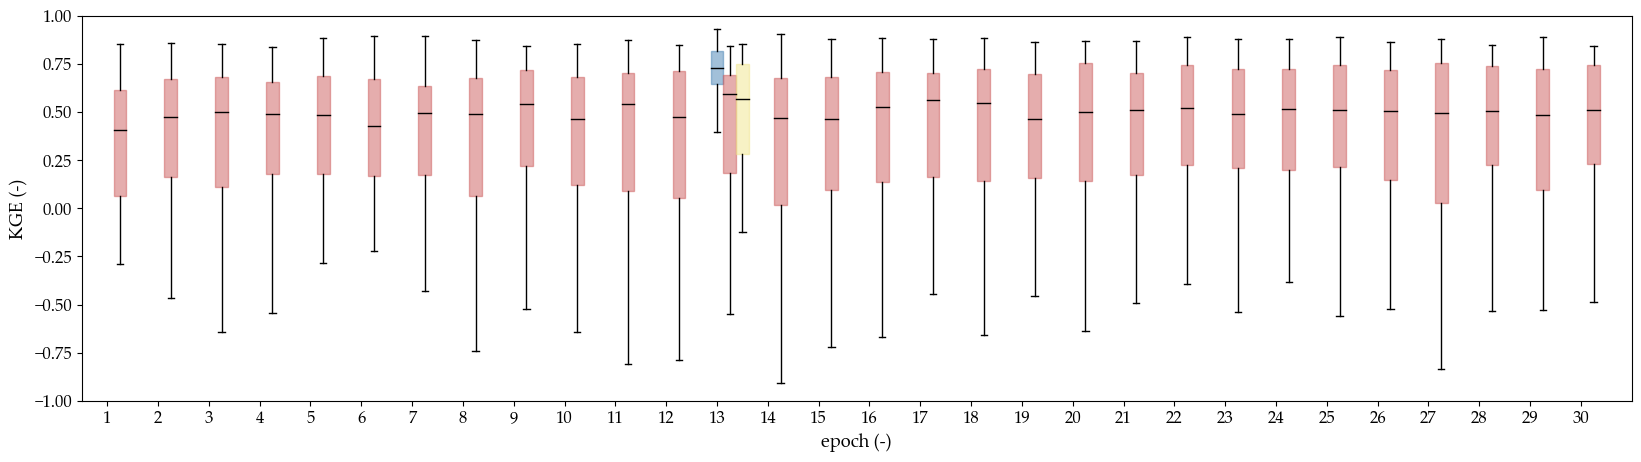

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'khaki']
for i, ((period, df), c) in enumerate(zip(metrics.items(), colors)):
    bp = ax.boxplot(df, positions=df.columns + i * .25, widths=0.25,
                    patch_artist=True,
                    boxprops={'color': c, 'alpha': .5},
                    # whiskerprops={},
                    showfliers=False,
                    medianprops={'color': 'k'})
    for box in bp['boxes']:
        box.set_facecolor(c)

ax.set_ylim(-1, 1);
xticks = np.linspace(1, epochs, num=epochs).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set(xlabel='epoch (-)',
       ylabel=f'{metric} (-)');

plt.savefig(run_dir / 'evolucion_KGE.jpg', dpi=300, bbox_inches='tight')

***Figura 1**. Evolución del rendimento en las muestra de entrenamiento (azul), validación (rojo) y evaluación (amarillo) en cada época.*

### Resultados mejor época

In [16]:
# mejor época de cada muestra y el rendimiento de cada muestra en esa época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))
epoch = best_epoch['validation']

epoch 13:	KGEtrain = 0.730   KGEval = 0.593   KGEtest = 0.570
epoch 13:	KGEtrain = 0.730   KGEval = 0.593   KGEtest = 0.570
epoch 13:	KGEtrain = 0.730   KGEval = 0.593   KGEtest = 0.570


In [17]:
# # simular entrenamiento y validación para la mejor época
# for period in tqdm(['train', 'test']):
#     eval_run(run_dir=run_dir, period=period, epoch=epoch, gpu=-1)

In [18]:
# fig, ax = plt.subplots(figsize=(20, 5))

# colors = ['steelblue', 'indianred', 'k']
# for (period, df), c in zip(metrics.items(), colors):
#     aux = df.quantile([.25, .5, .75])
#     ax.plot(aux.loc[.5], c=c, lw=1, label=period)
#     ax.axvline(best_epoch[period], lw=1, ls='--', c=c)
#     ax.fill_between(aux.columns, aux.loc[.25], aux.loc[.75], color=c, alpha=.1)
# ax.set(xlabel='epoch',
#        xlim=(1 - .2, epochs + .2),
#        ylabel='KGE (-)',
#        ylim=(-1.02, 1.02));
# fig.legend(frameon=False, loc=8, ncol=3, bbox_to_anchor=[.3, -0.05, .4, .05]);

In [19]:
# rendimiento y series simuladas de la mejor época
series = {}
rendimiento = pd.DataFrame()
for period in ['train', 'validation', 'test']:
    # importar resultados
    series_period, rend_period = get_results(run_dir, period, epoch=epoch)
    rend_period.columns = [period]
    series[period] = series_period
    rendimiento = pd.concat((rendimiento, rend_period), axis=1)

In [20]:
# hidrogramas
if hidrogramas:
    for period, dct in series.items():
        path = run_dir / 'hidrogramas' / period
        if path.exists() is False:
            path.mkdir(parents=True)
        plot_results(dct, period, target, save=path)

In [21]:
# añadir rendimiento al shapefile de subcuencas
kge = rendimiento.max(axis=1)
kge.name = 'KGE'
kge.index = kge.index.astype(str)
cuencas.loc[kge.index, 'KGE'] = kge#.loc[cuencas.index]
cuencas.sort_values('area_skm',ascending=False, inplace=True)

# export shapefile
cuencas.to_file(run_dir / 'cuencas_KGE.shp', index=True)

In [22]:
# añadir rendimiento en el shapefile de estaciones
estaciones['KGE'] = kge.loc[estaciones.index]

# export shapefile
estaciones.to_file(run_dir / 'estaciones_KGE.shp', index=True)

In [23]:
# función de densidad empírica de cada muestra
ecdf = {period: ECDF(rendimiento[period].dropna(), plot=False) for period in rendimiento.columns}
ecdf['EFAS'] = ecdf_efas

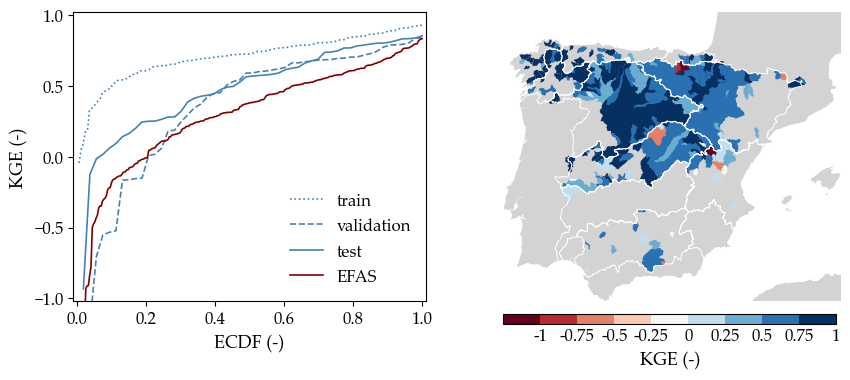

In [24]:
# figura con el rendimiento
rendimiento_LSTM(cuencas, ecdf, 'KGE', 'EFAS', demarcaciones, save=run_dir / 'rendimiento.jpg')

In [25]:
# # rendimiento vs área de cuenca
# plt.scatter(cuencas.area_skm, cuencas.KGE, c='steelblue', alpha=.5, s=5);